# Preprocessing
Let's check out the data and handle missing values etc.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os 

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), ".."))) # adds folder to Python path

Let's load the data

In [5]:

from src.data.load_data import load_data

claims_raw, claims_test = load_data(raw=True) # returns train and test dataframes
claims_raw.head()


FileNotFoundError: Training data not found at /data\raw\claims_raw_train.csv

Quick description

In [5]:
num_features = claims_raw.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = claims_raw.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical:", num_features)
print("Categorical:", cat_features)

target = ["ClaimNb", "Exposure"]
id_col = 'IDpol'

num_features = [c for c in num_features if c not in target]
cat_features = [c for c in cat_features if c is not id_col]


claims_raw.info()
claims_raw.shape

Numerical: ['IDpol', 'ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
Categorical: ['Area', 'VehBrand', 'VehGas', 'Region']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542410 entries, 0 to 542409
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       542410 non-null  float64
 1   ClaimNb     542410 non-null  int64  
 2   Exposure    542410 non-null  float64
 3   Area        542410 non-null  object 
 4   VehPower    542410 non-null  int64  
 5   VehAge      542410 non-null  int64  
 6   DrivAge     542410 non-null  int64  
 7   BonusMalus  542410 non-null  int64  
 8   VehBrand    542410 non-null  object 
 9   VehGas      542410 non-null  object 
 10  Density     542410 non-null  int64  
 11  Region      542410 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 49.7+ MB


(542410, 12)

Some objects that will need to be fixed, IDpol float? why?

In [6]:
print(((claims_raw['IDpol'] % 1) != 0).any())
claims_raw['IDpol'] = claims_raw['IDpol'].astype('int64').astype(str)

False


It should be a string, as it's just an identifier

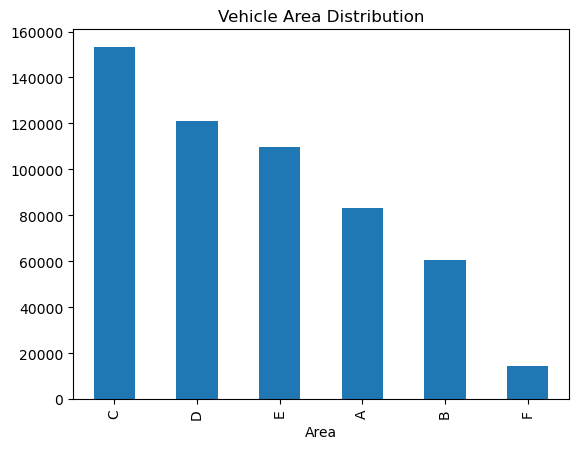

In [7]:
claims_raw["Area"].value_counts().plot(kind='bar')
plt.title("Vehicle Area Distribution")
plt.show()

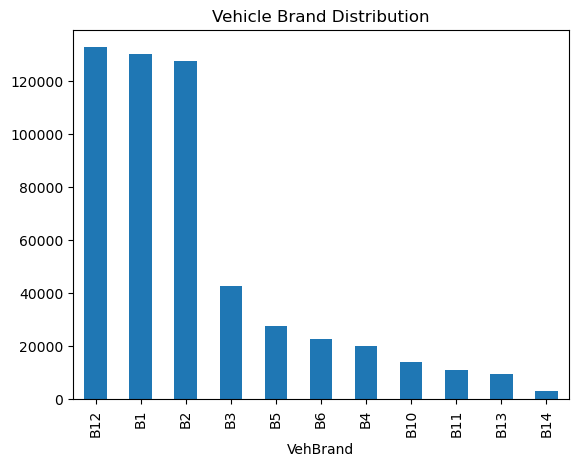

In [8]:
claims_raw["VehBrand"].value_counts().plot(kind='bar')
plt.title("Vehicle Brand Distribution")
plt.show()

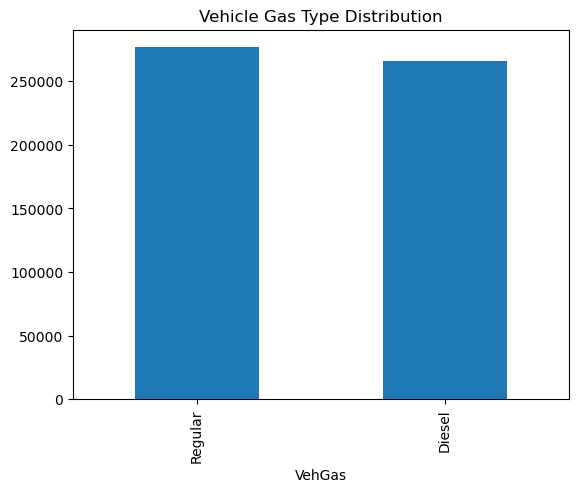

In [9]:
claims_raw["VehGas"].value_counts().plot(kind='bar')
plt.title("Vehicle Gas Type Distribution")
plt.show()

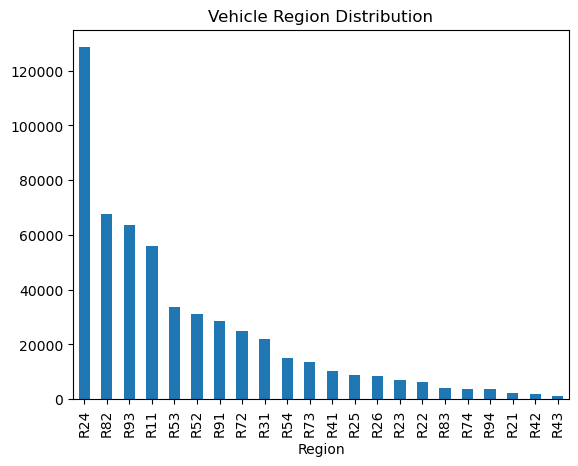

In [10]:
claims_raw["Region"].value_counts().plot(kind='bar')
plt.title("Vehicle Region Distribution")
plt.show()

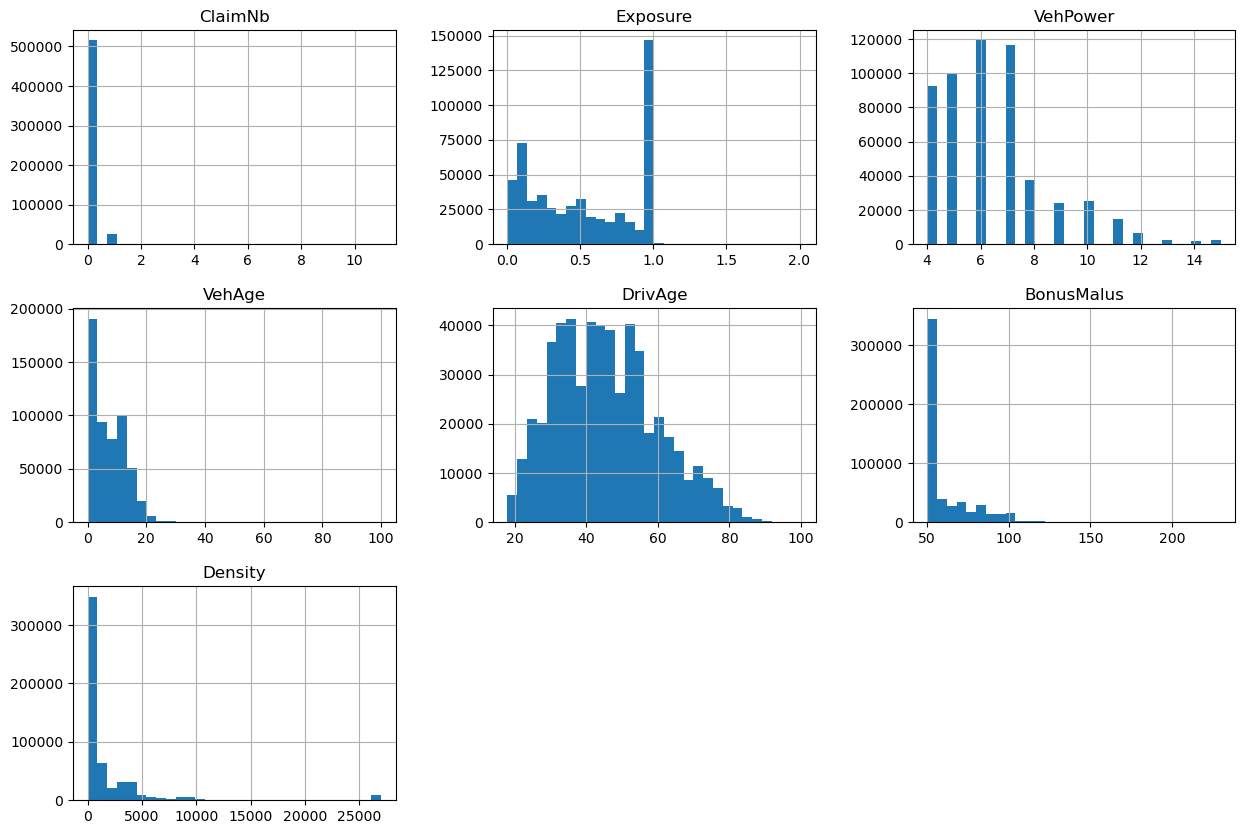

In [11]:
claims_raw.hist(bins=30, figsize=(15, 10))
plt.show()

In [12]:
claims_raw.isnull().sum()

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

In [13]:
claims_raw.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,542410.000000,542410.000000,542410.000000,542410.000000,542410.000000,542410.000000,542410.000000
mean,0.053122,0.528840,6.453281,7.045768,45.503164,59.761546,1796.176180
std,0.238785,0.364463,2.050506,5.660827,14.135435,15.639321,3965.475251
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1662.000000
max,11.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


So as we can see while there are no null values or missing cells, we have some major issues, for example outliers as well as skewed data, lets go over each features.

## Univariate analysis

### `ClaimNb`
Let's start with Numerical values and examine ClaimNb.

In [14]:
claims_raw["ClaimNb"].value_counts()


ClaimNb
0     515199
1      25718
2       1416
3         67
4          4
11         2
5          2
6          1
9          1
Name: count, dtype: int64

As we can see, close to 95% of the data has 0 claims and 4.7% has 1.

In [15]:
claims_raw['ClaimNb'].describe()

count    542410.000000
mean          0.053122
std           0.238785
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          11.000000
Name: ClaimNb, dtype: float64

super right-skewed, heavy-tailed distribution

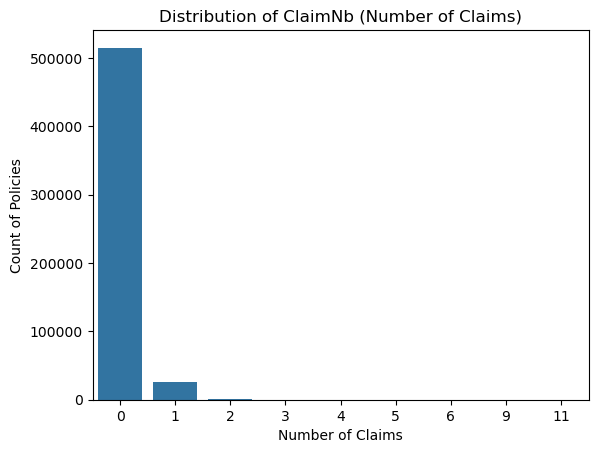

In [16]:
sns.countplot(x='ClaimNb', data=claims_raw)
plt.title("Distribution of ClaimNb (Number of Claims)")
plt.xlabel("Number of Claims")
plt.ylabel("Count of Policies")
plt.show()

In [17]:
from scipy.stats import skew

skew_value = skew(claims_raw['ClaimNb'])
print(f"Skewness: {skew_value:.3f}")

Skewness: 5.140


nothing is really visible, let's try log-scale

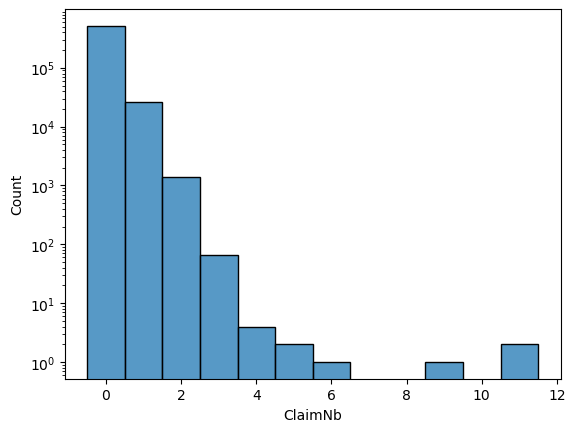

In [18]:
sns.histplot(claims_raw['ClaimNb'], bins=30, discrete=True)
plt.yscale('log')  # helps see rare high-claim values
plt.show()

In [19]:
no_claims = (claims_raw['ClaimNb'] == 0).mean()

As we can see, we have a few extreme outliers, (upto 11 claims!), they reflect high-risk cases and not data errors. These can also be fraud attempts/cases. As they are real errors, they should be kept, and treated carefully, but most likely some kind of tranformation is needed. We also have to take into consideration Exposure as its part of the target.

### `Exposure`

In [20]:
claims_raw['Exposure'].describe()

count    542410.000000
mean          0.528840
std           0.364463
min           0.002732
25%           0.180000
50%           0.490000
75%           0.990000
max           2.010000
Name: Exposure, dtype: float64

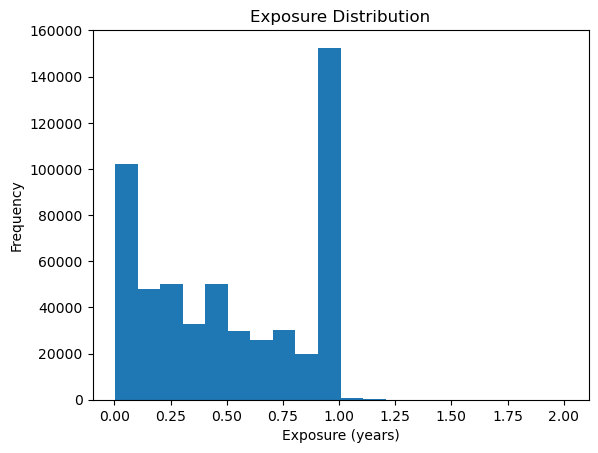

In [21]:
plt.hist(claims_raw['Exposure'], bins=20)
plt.title("Exposure Distribution")
plt.xlabel("Exposure (years)")
plt.ylabel("Frequency")
plt.show()


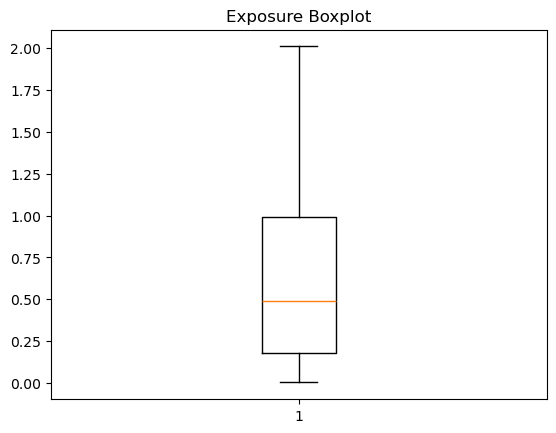

In [22]:
plt.boxplot(claims_raw['Exposure'])
plt.title("Exposure Boxplot")
plt.show()


From this we can see that most exposures are 1 year long or somewhere just over 0 year, so a short duration. As we can see from the histogram, Exposure seems to have a bimodal distributions with one mean around 0 and one mean around 1.
There are also some that are longer than 1 year, lets check these out as well.

count    994.000000
mean       1.115433
std        0.163890
min        1.010000
25%        1.020000
50%        1.040000
75%        1.150000
max        2.010000
Name: Exposure, dtype: float64


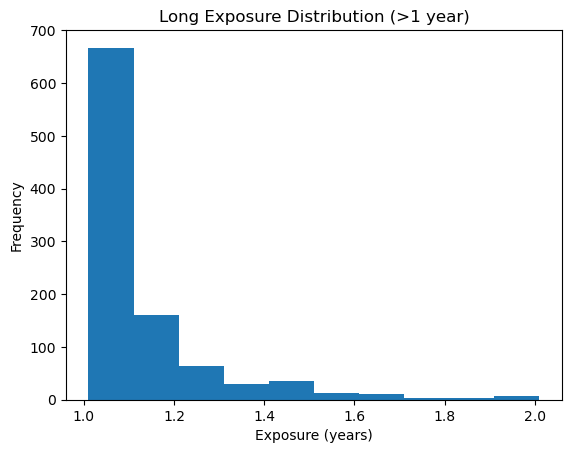

In [23]:
long_exposures = claims_raw[claims_raw['Exposure'] > 1]
print(long_exposures['Exposure'].describe())
plt.hist(long_exposures['Exposure'], bins=10)
plt.title("Long Exposure Distribution (>1 year)")
plt.xlabel("Exposure (years)")
plt.ylabel("Frequency")
plt.show()

Also, the smallest exposure is .00027 years long which is equal to roughly 2.5 hours. If the target variable will be Claims/Exposure, this could make the target incredibly large. These extreme value needs to be thought of later on.

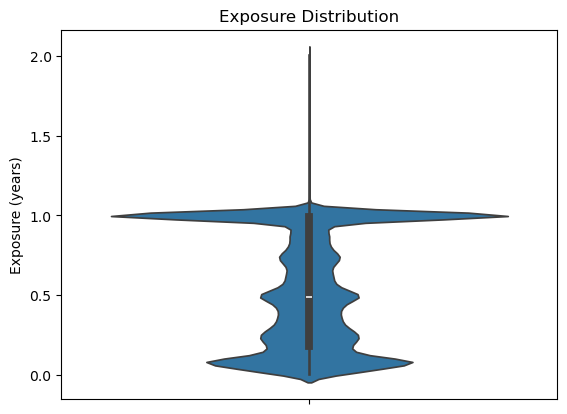

In [24]:
sns.violinplot(y=claims_raw['Exposure'])
plt.title("Exposure Distribution")
plt.ylabel("Exposure (years)")
plt.show()

The violin plot also helps to see how the data is distributed.

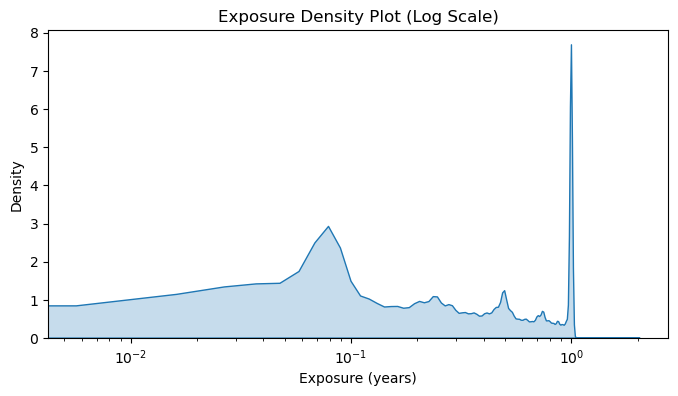

In [25]:
plt.figure(figsize=(8,4))
sns.kdeplot(claims_raw['Exposure'], bw_adjust=0.5, fill=True)
plt.xscale('log')
plt.title("Exposure Density Plot (Log Scale)")
plt.xlabel("Exposure (years)")
plt.show()

The KDE plot also shows the bimodality. 
<p> so overall the data is bimodal, the minimum is extremely low the maximum is 2. Exposure will be essential for normalizing claimsNb

### `VehPower`

In [26]:
claims_raw["VehPower"].describe()

count    542410.000000
mean          6.453281
std           2.050506
min           4.000000
25%           5.000000
50%           6.000000
75%           7.000000
max          15.000000
Name: VehPower, dtype: float64

In [27]:
claims_raw["VehPower"].value_counts()

VehPower
6     119230
7     116340
5      99841
4      92413
8      37369
10     25159
9      24080
11     14652
12      6515
13      2582
15      2321
14      1908
Name: count, dtype: int64

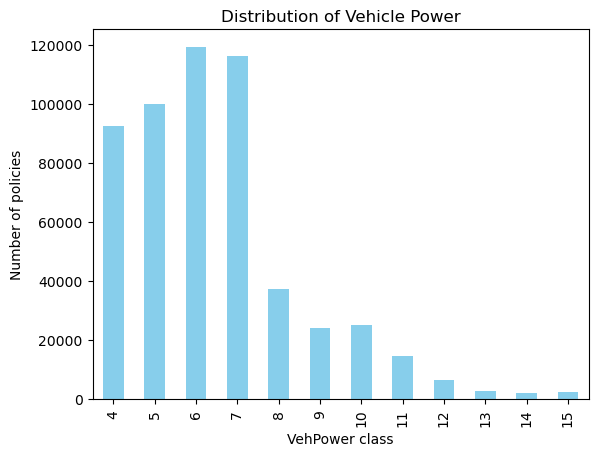

In [28]:
claims_raw['VehPower'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel("VehPower class")
plt.ylabel("Number of policies")
plt.title("Distribution of Vehicle Power")
plt.show()

This feature is just rating classes. We know from the documentation that higher values correspond to highervehicle power. As these are discrete categories and not continous values, for linear models or neural networks it might be worth treating these as categoires, as we dont know if the difference between 6 and 7 is the same as the difference between 12 and 13.
<p> What we can observe though, is that most people who have insurances have lower power cars. This could be simply because most people have lower power rating cars and only rich people have high ones.

### `VehAge`

In [29]:
claims_raw["VehAge"].describe()

count    542410.000000
mean          7.045768
std           5.660827
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max         100.000000
Name: VehAge, dtype: float64

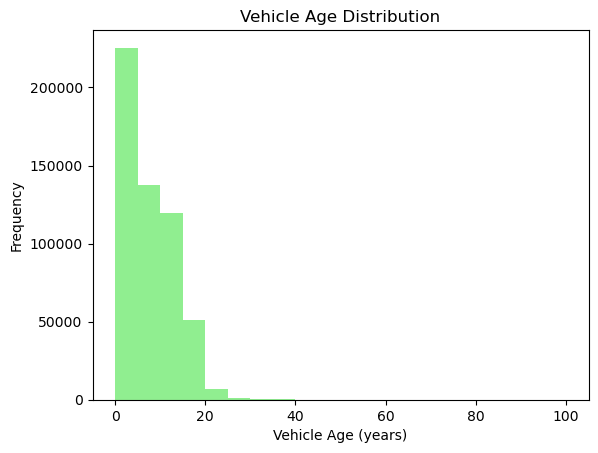

In [30]:
plt.hist(claims_raw['VehAge'], bins=20, color='lightgreen')
plt.title("Vehicle Age Distribution")
plt.xlabel("Vehicle Age (years)")
plt.ylabel("Frequency")
plt.show()

In [31]:
skew_value = skew(claims_raw['VehAge'])
print(f"Skewness: {skew_value:.3f}")

Skewness: 1.136


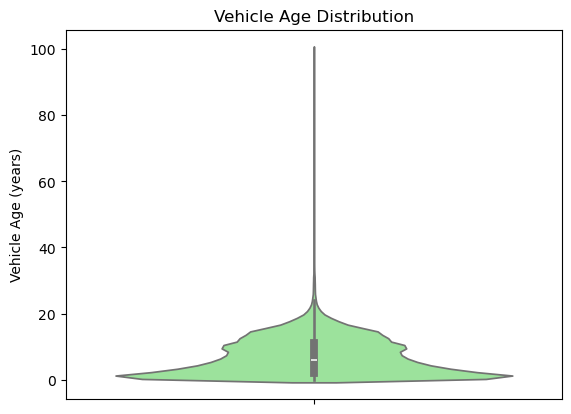

In [32]:
sns.violinplot(y=claims_raw['VehAge'], color='lightgreen')
plt.title("Vehicle Age Distribution")
plt.ylabel("Vehicle Age (years)")
plt.show()


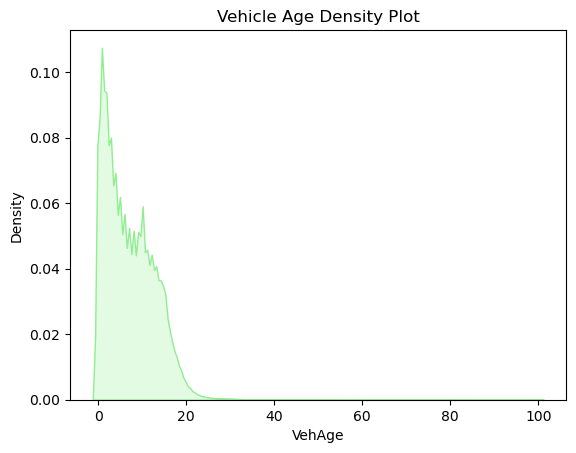

In [33]:
sns.kdeplot(claims_raw['VehAge'], fill=True, color='lightgreen')
plt.title("Vehicle Age Density Plot")
plt.show()

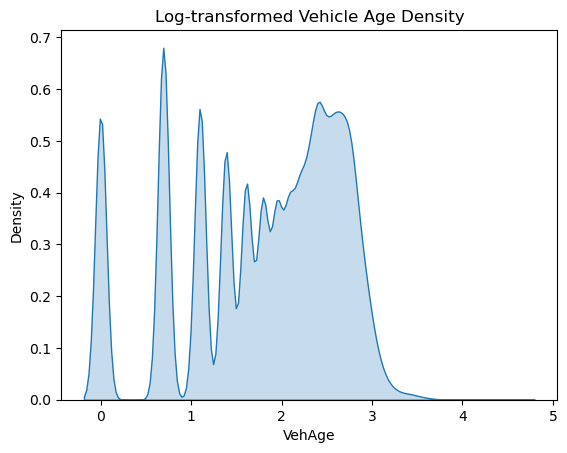

In [34]:
sns.kdeplot(np.log1p(claims_raw['VehAge']), fill=True)
plt.title("Log-transformed Vehicle Age Density")
plt.show()



`VehAge` represents the age of the vehicle in years. The distribution is right-skewed, with most vehicles being relatively new (0–5 years) and fewer older vehicles forming a long tail. The ages in the dataset typically range from 0 to around 15 years, with occasional older vehicles appearing as outliers. This skew suggests that for some models, applying a log transformation or binning the feature could help reduce the influence of extreme values. A histogram or violinplot effectively illustrates the concentration of newer vehicles and the presence of older ones in the dataset.

### `DrivAge`


In [35]:
claims_raw["DrivAge"].describe()

count    542410.000000
mean         45.503164
std          14.135435
min          18.000000
25%          34.000000
50%          44.000000
75%          55.000000
max         100.000000
Name: DrivAge, dtype: float64

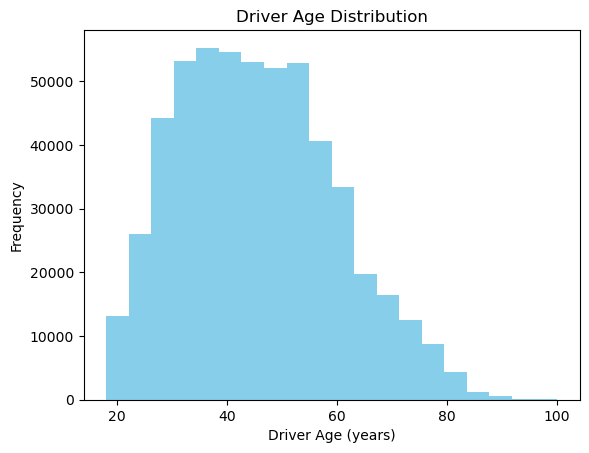

In [36]:
plt.hist(claims_raw['DrivAge'], bins=20, color='skyblue')
plt.title("Driver Age Distribution")
plt.xlabel("Driver Age (years)")
plt.ylabel("Frequency")
plt.show()


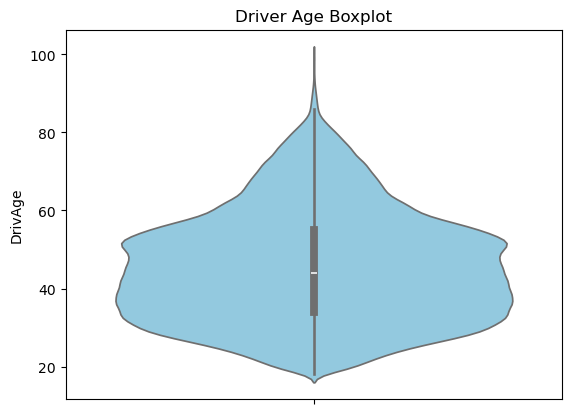

In [37]:
sns.violinplot(y=claims_raw['DrivAge'], color='skyblue')
plt.title("Driver Age Boxplot")
plt.show()


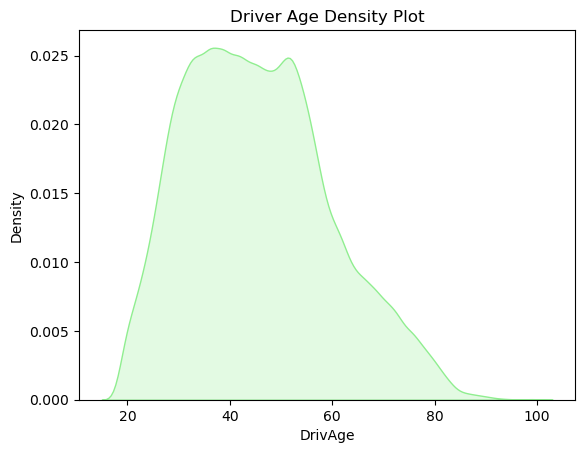

In [38]:
sns.kdeplot(claims_raw['DrivAge'], fill=True, color='lightgreen')
plt.title("Driver Age Density Plot")
plt.show()


In [39]:

skew_value = skew(claims_raw['DrivAge'])
print(f"Skewness: {skew_value:.3f}")

Skewness: 0.436


`DrivAge` represents the age of the principal driver in years. The distribution is mildly right-skewed, with most drivers clustered in the young adult to middle-aged range, and relatively few very young or very old drivers. The ages in the dataset span from around 18 to 100 years, with extreme values being rare. Compared to highly skewed variables like `VehAge`, the skewness of `DrivAge` is minor (≈0.43), suggesting that it can generally be used as-is for modeling, though optional binning into age groups could improve interpretability in some models. Visualization via histogram or KDE illustrates the concentration of drivers in the middle age ranges and the tapering of older or younger extremes.

### `Density`

In [40]:
claims_raw['Density'].describe()


count    542410.000000
mean       1796.176180
std        3965.475251
min           1.000000
25%          92.000000
50%         393.000000
75%        1662.000000
max       27000.000000
Name: Density, dtype: float64

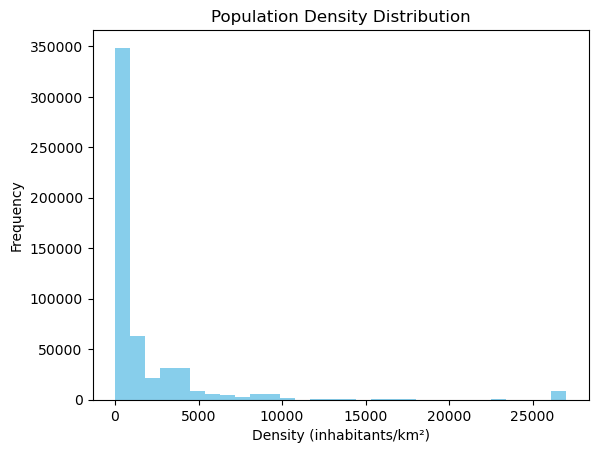

In [41]:
plt.hist(claims_raw['Density'], bins=30, color='skyblue')
plt.title("Population Density Distribution")
plt.xlabel("Density (inhabitants/km²)")
plt.ylabel("Frequency")
plt.show()


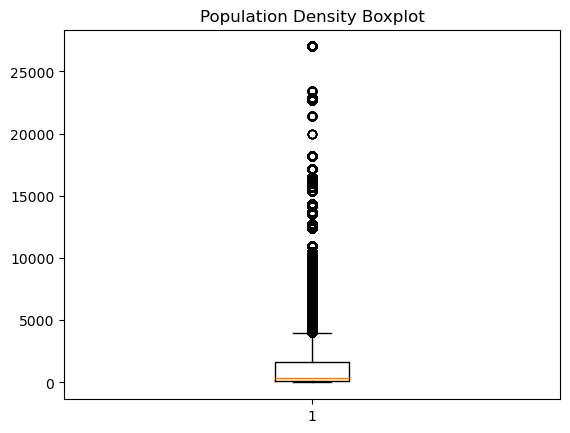

In [42]:
plt.boxplot(claims_raw['Density'])
plt.title("Population Density Boxplot")
plt.show()


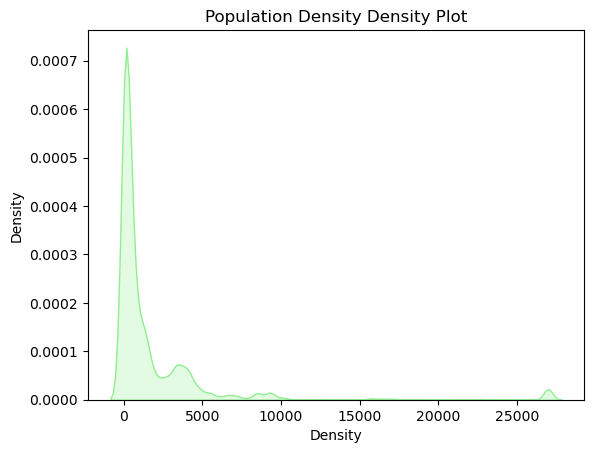

In [43]:
sns.kdeplot(claims_raw['Density'], fill=True, color='lightgreen')
plt.title("Population Density Density Plot")
plt.show()


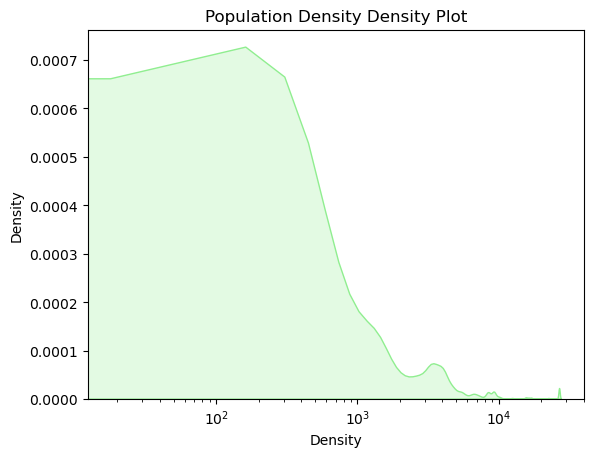

In [44]:
sns.kdeplot(claims_raw['Density'], fill=True, color='lightgreen')
plt.title("Population Density Density Plot")
plt.xscale('log')
plt.show()


In [45]:
# Very low densities
claims_raw[claims_raw['Density'] < 50]['Density'].describe()


count    82411.000000
mean        27.284792
std         12.369511
min          1.000000
25%         16.000000
50%         27.000000
75%         38.000000
max         49.000000
Name: Density, dtype: float64

In [46]:
# High densities
claims_raw[claims_raw['Density'] > 10000]['Density'].describe()

count    14404.000000
mean     22030.834699
std       6382.406020
min      10008.000000
25%      16052.000000
50%      27000.000000
75%      27000.000000
max      27000.000000
Name: Density, dtype: float64

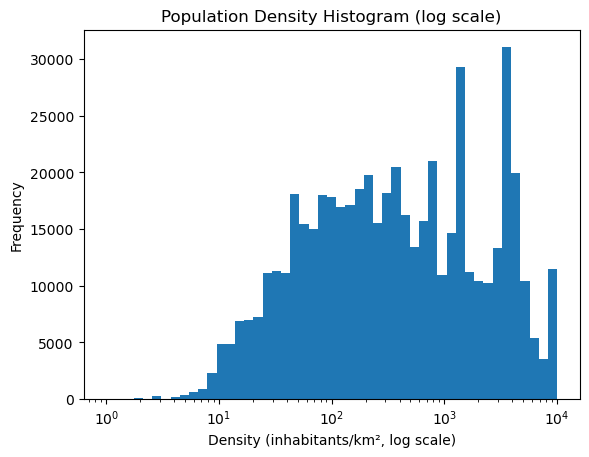

In [47]:
plt.hist(claims_raw['Density'], bins=np.logspace(0, 4, 50))
plt.xscale('log')
plt.xlabel("Density (inhabitants/km², log scale)")
plt.ylabel("Frequency")
plt.title("Population Density Histogram (log scale)")
plt.show()


In [48]:
skew_value = skew(claims_raw['Density'])
print(f"Skewness: {skew_value:.3f}")

Skewness: 4.645



`Density` represents the number of inhabitants per square kilometer in the driver’s area. The raw distribution is highly right-skewed, with most drivers living in low-to-moderate density areas and a few living in very densely populated regions, creating a small bump at the maximum. Applying a log transformation to the feature makes the bulk of the distribution roughly symmetric while still showing the extreme urban clusters as separate peaks. For modeling, the skew suggests that a log transformation or binning into categories (e.g., low, medium, high, very high density) could help reduce the influence of extreme values while preserving meaningful variation.
### `BonusMalus`

In [49]:
claims_raw["BonusMalus"].describe()

count    542410.000000
mean         59.761546
std          15.639321
min          50.000000
25%          50.000000
50%          50.000000
75%          64.000000
max         230.000000
Name: BonusMalus, dtype: float64

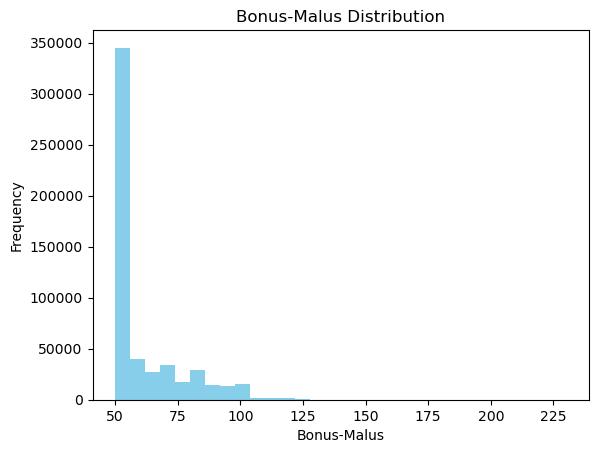

In [50]:
plt.hist(claims_raw['BonusMalus'], bins=30, color='skyblue')
plt.title("Bonus-Malus Distribution")
plt.xlabel("Bonus-Malus")
plt.ylabel("Frequency")
plt.show()


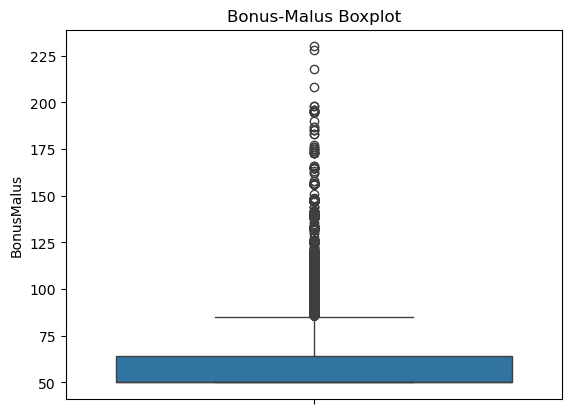

In [51]:
sns.boxplot(claims_raw['BonusMalus'])
plt.title("Bonus-Malus Boxplot")
plt.show()


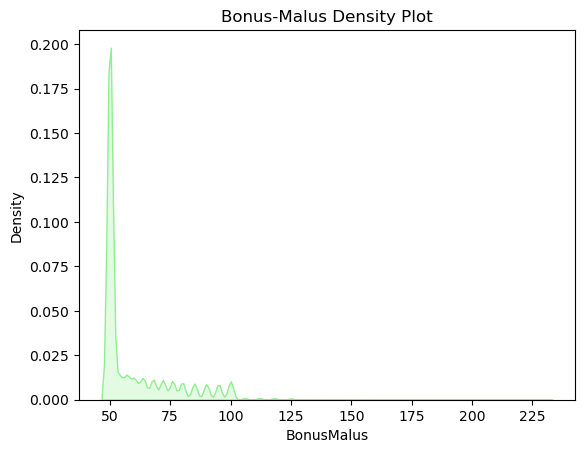

In [52]:
sns.kdeplot(claims_raw['BonusMalus'], fill=True, color='lightgreen')
plt.title("Bonus-Malus Density Plot")
plt.show()


In [53]:
skew_value = skew(claims_raw['BonusMalus'])
print(f"Skewness: {skew_value:.3f}")

Skewness: 1.730


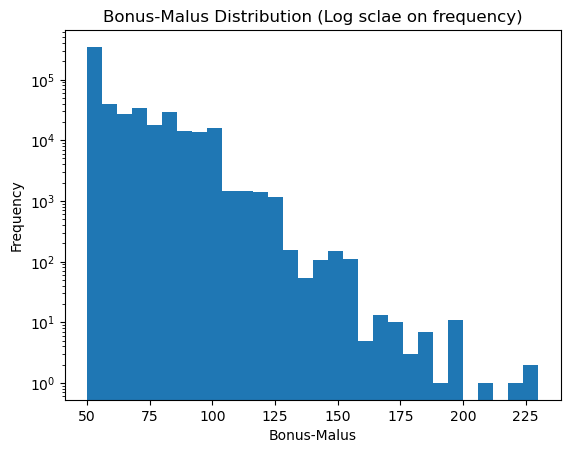

In [54]:
plt.hist(claims_raw['BonusMalus'], bins=30)
plt.title("Bonus-Malus Distribution (Log sclae on frequency)")
plt.xlabel("Bonus-Malus")
plt.yscale("log")
plt.ylabel("Frequency")
plt.show()




`BonusMalus` represents the driver’s insurance score, where values below 100 indicate a bonus (good driving record) and values above 100 indicate a malus (worse record). The distribution is heavily right-skewed, with the majority of drivers clustered in the bonus range and a long tail of high malus values. Log-scaling does not significantly normalize the distribution due to its narrow range, so visualizations such as violin plots with overlaid points or histograms with custom bins are recommended to clearly display both the dense bulk and the extreme malus tail. For modeling, the skew can be addressed by binning into categories or applying mild transformations if needed.
<p> Now let's do the categorical features.


### `VehBrand`

In [55]:
claims_raw["VehBrand"].unique()

array(['B1', 'B2', 'B6', 'B13', 'B11', 'B5', 'B12', 'B3', 'B10', 'B4',
       'B14'], dtype=object)

In [56]:
claims_raw["VehBrand"].value_counts()

VehBrand
B12    132831
B1     130256
B2     127821
B3      42682
B5      27850
B6      22754
B4      20186
B10     14220
B11     10889
B13      9680
B14      3241
Name: count, dtype: int64

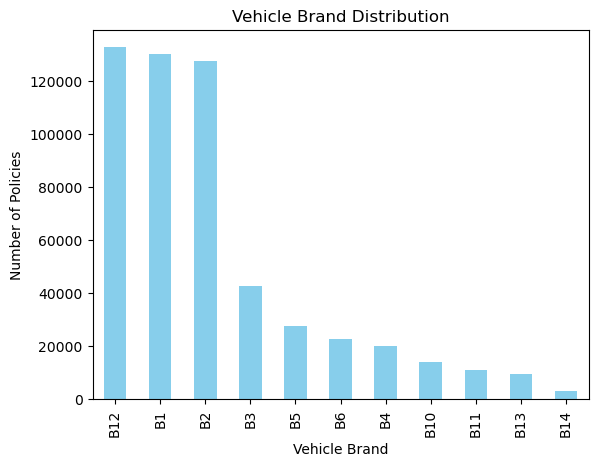

In [57]:
claims_raw['VehBrand'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Vehicle Brand Distribution")
plt.xlabel("Vehicle Brand")
plt.ylabel("Number of Policies")
plt.show()




`VehBrand` represents the anonymized vehicle brand category. There are 11 brands in the dataset, with `B12`, `B1`, and `B2` being the most common, while the remaining brands occur less frequently but without extreme imbalance.  The distribution is mildy uneven, but all categories have sufficient representation for modeling. For modeling purposes, the feature can be treated as categorical, with one-hot encoding recommended for linear models or neural networks, and numeric encoding acceptable for tree-based models.


### `VehGas`

In [58]:
claims_raw["VehGas"].unique()

array(['Regular', 'Diesel'], dtype=object)

In [59]:
claims_raw["VehGas"].value_counts(normalize=True)

VehGas
Regular    0.510173
Diesel     0.489827
Name: proportion, dtype: float64

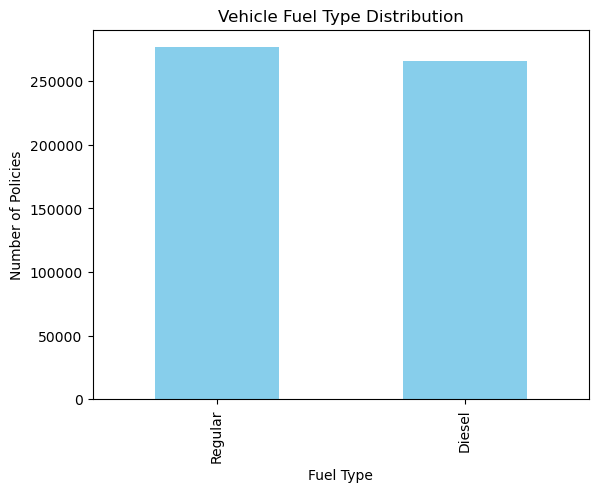

In [60]:
claims_raw['VehGas'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Vehicle Fuel Type Distribution")
plt.xlabel("Fuel Type")
plt.ylabel("Number of Policies")
plt.show()



`VehGas` represents the fuel type of the vehicle. The dataset contains two categories: `Regular` (51%) and `Diesel` (49%), showing an almost even split. There are no  unexpected values. This binary feature is clean and balanced, and can be directly used for modeling, with binary or one-hot encoding as appropriate for the chosen algorithm.

### `Area` 

In [61]:
claims_raw["Area"].unique()

array(['D', 'E', 'A', 'C', 'B', 'F'], dtype=object)

In [62]:
print(claims_raw["Area"].value_counts(normalize=True))

Area
C    0.282604
D    0.223512
E    0.202635
A    0.153297
B    0.111397
F    0.026556
Name: proportion, dtype: float64


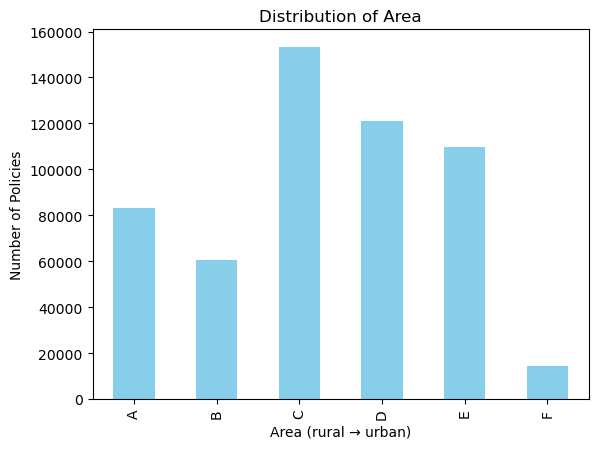

In [63]:
claims_raw['Area'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Distribution of Area")
plt.xlabel("Area (rural → urban)")
plt.ylabel("Number of Policies")
plt.show()


`Area` is an ordinal feature representing the type of location, from most rural (`A`) to more urban (`F`). The distribution shows that most policies are in moderately populated areas: `C` (28%), `D` (22%), and `E` (20%). Fewer policies are in the most rural areas, `A` (15%) and `B` (11%), while very sparsely populated areas `F` account for only 2.6% of policies. The ordinal nature of the feature makes it suitable for both ordinal encoding or one-hot encoding in modeling.


### `Region`

In [64]:
claims_raw['Region'].unique()

array(['R24', 'R25', 'R82', 'R53', 'R54', 'R11', 'R94', 'R93', 'R91',
       'R52', 'R72', 'R31', 'R73', 'R23', 'R22', 'R41', 'R42', 'R83',
       'R21', 'R26', 'R74', 'R43'], dtype=object)

In [65]:
claims_raw['Region'].value_counts(normalize=True)


Region
R24    0.236909
R82    0.124946
R93    0.117101
R11    0.103213
R53    0.062025
R52    0.057045
R91    0.052953
R72    0.046026
R31    0.040215
R54    0.028071
R73    0.025313
R41    0.019129
R25    0.016054
R26    0.015405
R23    0.012972
R22    0.011794
R83    0.007821
R74    0.006770
R94    0.006624
R21    0.004428
R42    0.003230
R43    0.001954
Name: proportion, dtype: float64

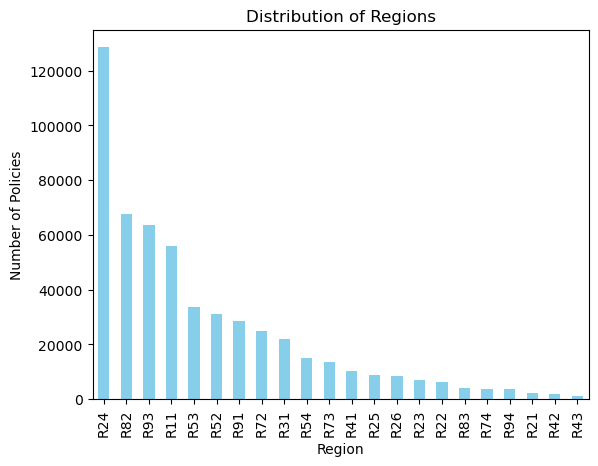

In [66]:


claims_raw['Region'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribution of Regions")
plt.xlabel("Region")
plt.ylabel("Number of Policies")
plt.show()


`Region` represents the administrative area where the policyholder resides. The dataset includes 22 regions, with `R24` (23.7%), `R82`, `R93`, and `R11` being the most represented. The remaining regions each account for smaller but non-negligible proportions. The distribution is uneven but not extreme, making the feature suitable for one-hot encoding in modeling.


### Univariate Analysis Summary

The univariate exploration provided an overview of the distributions and characteristics of all key features in the dataset. Most numeric variables, such as `ClaimNb`, `VehAge`, and `BonusMalus`, showed strong right skewness, while `DrivAge` and `Exposure` were more balanced, with `Exposure` exhibiting a bimodal pattern around 0 and 1. Among categorical features, `VehBrand` and `VehGas` were evenly distributed, with `B12`, `B1`, and `B2` being the most common brands, and fuel type split almost evenly between regular and diesel. The `Area` feature displayed an ordinal pattern with most policies in moderately populated regions, and `Region` showed geographic imbalance, with a few regions dominating. Overall, no invalid or missing values were detected, and all features fall within reasonable ranges, requiring minimal cleaning before further analysis.


## Bivariate analysis

Let's move on to bivariate analysis, and analyze the connection between features and target and features.

In [1]:
claims_raw["ClaimRate"] = claims_raw["ClaimNb"] / claims_raw["Exposure"]
claims_raw["ClaimRate"].describe()
plt.hist(claims_raw['ClaimRate'], bins=20)
plt.yscale('log')
plt.show()
claims_raw["ClaimRate"].value_counts()

NameError: name 'claims_raw' is not defined

In [68]:
# correlation with claimrate
correlations = claims_raw[num_features + ['ClaimRate']].corr()['ClaimRate'].sort_values()
print(correlations)

IDpol        -0.055068
VehAge       -0.023962
DrivAge      -0.003344
VehPower     -0.001430
Density       0.005868
BonusMalus    0.013873
ClaimRate     1.000000
Name: ClaimRate, dtype: float64


Saving processed data

In [70]:
processed_df_train = claims_raw.copy()
processed_df_test = claims_test.copy()
processed_df_train["ClaimRate"] = claims_raw["ClaimNb"] / claims_raw["Exposure"]
processed_df_test["ClaimRate"] = claims_test["ClaimNb"] / claims_test["Exposure"]
processed_df_train.drop(columns=["ClaimNb", "Exposure", "IDpol"], inplace=True)
processed_df_test.drop(columns=["ClaimNb", "Exposure", "IDpol"], inplace=True)
out_dir = "../data/processed"
os.makedirs(out_dir, exist_ok=True)
processed_df_train.to_csv("../data/processed/clean_data_train.csv", index=False)
processed_df_test.to_csv("../data/processed/clean_data_test.csv", index=False)